In [1]:
!pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv("/content/water quality.csv")

# ===============================
# Step 1: Data Cleaning
# ===============================

# Check for nulls and impute if necessary
imputer = SimpleImputer(strategy='mean')
df.iloc[:, :-2] = imputer.fit_transform(df.iloc[:, :-2])  # Skip Potability and Diseases for imputation

# Fix column names if needed (based on image)
df.columns = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
              'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability', 'Diseases']

# Drop 'Potability' if not useful in prediction (based on image it's always 0)
df.drop(columns=['Potability'], inplace=True)

# ===============================
# Step 2: Feature Scaling
# ===============================

scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Diseases', axis=1))

# ===============================
# Step 3: Encode Target Variable
# ===============================

le = LabelEncoder()
y = le.fit_transform(df['Diseases'])

# ===============================
# Step 4: Train-Test Split
# ===============================

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ===============================
# Step 5: Model Training
# ===============================

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000)
}
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(...)),
    ('xgb', XGBClassifier(...))
], voting='soft')

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        "accuracy": acc,
        "report": report,
        "confusion_matrix": cm
    }

# ===============================
# Step 6: Results Summary
# ===============================

for model_name, metrics in results.items():
    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print("Classification Report:")
    print(metrics['report'])
    print("Confusion Matrix:")
    print(metrics['confusion_matrix'])


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:723: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:19:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== RandomForest ===
Accuracy: 0.8450
Classification Report:
              precision    recall  f1-score   support

     CHOLERA       0.78      0.70      0.74        20
    DYSENTRY       0.88      0.72      0.79        29
  GIARDIASIS       0.85      0.88      0.86        25
  HEPTATIS A       0.95      0.83      0.88        23
  NO DISEASE       0.78      0.91      0.84        44
       POLIO       0.87      0.93      0.90        28
     TYPHOID       0.87      0.87      0.87        31

    accuracy                           0.84       200
   macro avg       0.85      0.83      0.84       200
weighted avg       0.85      0.84      0.84       200

Confusion Matrix:
[[14  0  1  0  5  0  0]
 [ 2 21  0  1  3  2  0]
 [ 0  1 22  0  0  2  0]
 [ 0  2  1 19  0  0  1]
 [ 0  0  1  0 40  0  3]
 [ 2  0  0  0  0 26  0]
 [ 0  0  1  0  3  0 27]]

=== XGBoost ===
Accuracy: 0.8300
Classification Report:
              precision    recall  f1-score   support

     CHOLERA       0.88      0.70      0.7

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# === Step 1: Load Data ===
data = pd.read_csv('/content/water quality.csv')

# === Step 2: Preprocessing ===

data.drop('Potability', axis=1, inplace=True)

# Define features and target
X = data.drop('Diseases', axis=1)
y = data['Diseases']


# Identify numerical and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Define transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# === Step 3: Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# === Step 4: Apply SMOTE to Training Data Only ===
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_preprocessed, y_train)

# === Step 5: Model Training with Hyperparameter Tuning ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rfc = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_resampled, y_resampled)

# === Step 6: Final Evaluation ===
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_preprocessed)

print("Best Parameters:\n", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# === Optional: Save the Model ===
import joblib
joblib.dump(best_model, 'randomforest_best_model.pkl')

joblib.dump(preprocessor, 'preprocessor.pkl')


Best Parameters:
 {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.845
Classification Report:
               precision    recall  f1-score   support

     CHOLERA       0.70      0.80      0.74        20
    DYSENTRY       0.88      0.79      0.84        29
  GIARDIASIS       0.88      0.88      0.88        25
  HEPTATIS A       0.87      0.87      0.87        23
  NO DISEASE       0.79      0.86      0.83        44
       POLIO       0.87      0.93      0.90        28
     TYPHOID       0.96      0.77      0.86        31

    accuracy                           0.84       200
   macro avg       0.85      0.84      0.84       200
weighted avg       0.85      0.84      0.85       200



['preprocessor.pkl']

In [ ]:
import pandas as pd
import numpy as np
import joblib

# Load the saved model and preprocessor
model = joblib.load('randomforest_best_model.pkl')
preprocessor = joblib.load('preprocessor.pkl')  # assuming you saved it

# Define the input manually
manual_input = {
    'ph': 7.2,
    'Hardness': 180.0,
    'Solids': 15000.0,
    'Chloramines': 7.5,
    'Sulfate': 310.0,
    'Conductivity': 520.0,
    'Organic_carbon': 10.5,
    'Trihalomethanes': 80.0,
    'Turbidity': 3.2}

# Convert to DataFrame
input_df = pd.DataFrame([manual_input])

# Preprocess the input
input_processed = preprocessor.transform(input_df)

# Predict the disease
prediction = model.predict(input_processed)

print(f"Predicted Disease: {prediction[0]}")


Predicted Disease: TYPHOID


In [ ]:
import pandas as pd
import joblib

# Load trained model and preprocessor
model = joblib.load('randomforest_best_model.pkl')
preprocessor = joblib.load('preprocessor.pkl')  # Make sure this was saved during training

# Define the input features (excluding the target)
feature_names = [
    'ph',
    'Hardness',
    'Solids',
    'Chloramines',
    'Sulfate',
    'Conductivity',
    'Organic_carbon',
    'Trihalomethanes',
    'Turbidity',
 ]

# Prompt user for input
print("Please enter the following water quality parameters:")

user_input = {}
for feature in feature_names:
    value = float(input(f"Enter {feature}: "))
    user_input[feature] = value

# Convert input to DataFrame
input_df = pd.DataFrame([user_input])

# Preprocess the input using saved pipeline
input_processed = preprocessor.transform(input_df)

# Predict disease
prediction = model.predict(input_processed)

print(f"\n✅ Predicted Disease: {prediction[0]}")


Please enter the following water quality parameters:
Enter ph: 5.58
Enter Hardness: 188.10
Enter Solids: 17978
Enter Chloramines: 7.544
Enter Sulfate: 326.77
Enter Conductivity: 283.65
Enter Organic_carbon: 13.789
Enter Trihalomethanes: 84.60
Enter Turbidity: 2.45

✅ Predicted Disease: POLIO


In [1]:
# !pip install pycaret

In [18]:
import pandas as pd
from pycaret.classification import *

# Load the dataset
df = pd.read_excel("/content/water quality.xlsx",sheet_name='Sheet1')

# Fix column names (if needed)
df.columns = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
              'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability', 'Diseases']

# Drop 'Potability' as mentioned
df.drop(columns=['Potability'], inplace=True)

# Setup PyCaret
clf1 = setup(
    data=df,
    target='Diseases',
    imputation_type='simple',
    numeric_imputation='mean',
    normalize=True,
    session_id=42,
    verbose=False
)

# ===============================
# Step 1: Model Comparison
# ===============================

best_model = compare_models()

# Show metrics of the best model
print("\n=== Default Best Model Metrics ===")
evaluate_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7120,0.9227,0.7120,0.7301,0.7045,0.6575,0.6626,0.4970
et,Extra Trees Classifier,0.7007,0.9401,0.7007,0.7175,0.6922,0.6442,0.6493,0.3850
lightgbm,Light Gradient Boosting Machine,0.6964,0.9234,0.6964,0.7060,0.6891,0.6397,0.6433,3.3550
xgboost,Extreme Gradient Boosting,0.6906,0.9186,0.6906,0.7062,0.6851,0.6334,0.6370,0.5460
gbc,Gradient Boosting Classifier,0.6891,0.0000,0.6891,0.7033,0.6827,0.6314,0.6348,1.9140
dt,Decision Tree Classifier,0.6504,0.7946,0.6504,0.6750,0.6474,0.5877,0.5915,0.0770
qda,Quadratic Discriminant Analysis,0.3825,0.0000,0.3825,0.3753,0.3651,0.2646,0.2683,0.0400
nb,Naive Bayes,0.3710,0.7438,0.3710,0.3054,0.3223,0.2438,0.2507,0.0670
lr,Logistic Regression,0.3465,0.0000,0.3465,0.3002,0.3024,0.2132,0.2201,1.2740
lda,Linear Discriminant Analysis,0.3465,0.0000,0.3465,0.3015,0.3031,0.2128,0.2197,0.0400


Processing:   0%|          | 0/65 [00:00<?, ?it/s]


=== Default Best Model Metrics ===


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5000,0.8597,0.5000,0.5669,0.4583,0.3994,0.4180
1,0.5571,0.8659,0.5571,0.6132,0.5313,0.4688,0.4806
2,0.5286,0.8647,0.5286,0.5686,0.4952,0.4322,0.4468
3,0.5429,0.8745,0.5429,0.5481,0.5155,0.4507,0.4623
4,0.5571,0.8725,0.5571,0.6083,0.5388,0.4703,0.4783
5,0.5857,0.8885,0.5857,0.5617,0.5502,0.5027,0.5139
6,0.6143,0.9109,0.6143,0.6467,0.5701,0.5325,0.5535
7,0.6000,0.8708,0.6000,0.6652,0.5785,0.5184,0.5276
8,0.6232,0.8580,0.6232,0.6951,0.5956,0.5486,0.5646


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

=== Tuned Model Metrics ===


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


Classification Report (Tuned):
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.5000  0.8597  0.5000  0.5669  0.4583  0.3994  0.4180
1       0.5571  0.8659  0.5571  0.6132  0.5313  0.4688  0.4806
2       0.5286  0.8647  0.5286  0.5686  0.4952  0.4322  0.4468
3       0.5429  0.8745  0.5429  0.5481  0.5155  0.4507  0.4623
4       0.5571  0.8725  0.5571  0.6083  0.5388  0.4703  0.4783
5       0.5857  0.8885  0.5857  0.5617  0.5502  0.5027  0.5139
6       0.6143  0.9109  0.6143  0.6467  0.5701  0.5325  0.5535
7       0.6000  0.8708  0.6000  0.6652  0.5785  0.5184  0.5276
8       0.6232  0.8580  0.6232  0.6951  0.5956  0.5486  0.5646
9       0.5217  0.8629  0.5217  0.5463  0.4833  0.4237  0.4445
Mean    0.5631  0.8728  0.5631  0.6020  0.5317  0.4747  0.4890
Std     0.0393  0.0152  0.0393  0.0498  0.0418  0.0471  0.0466


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7267,0.9208,0.7267,0.7327,0.7214,0.6756,0.6780



Confusion Matrix (Tuned):


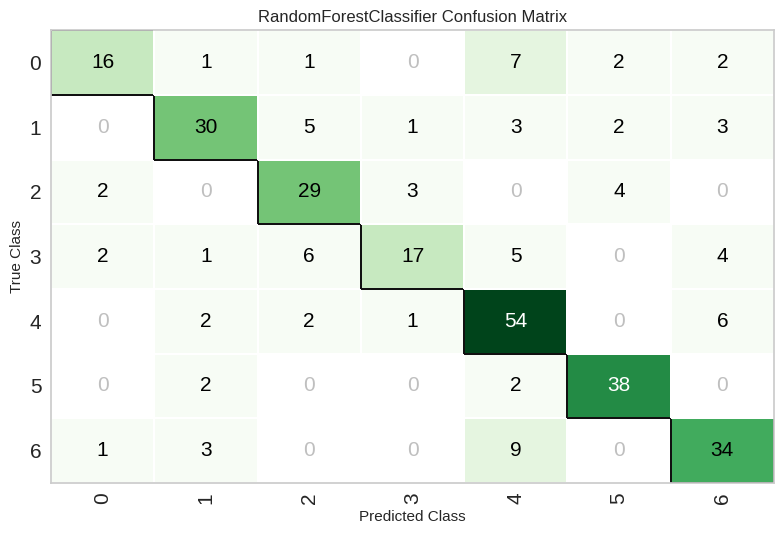

In [19]:
# ===============================
# Step 2: Fine-Tuning the Best Model
# ===============================

tuned_model = tune_model(best_model)

# Show metrics of the tuned model
print("\n=== Tuned Model Metrics ===")
evaluate_model(tuned_model)

# Optionally, you can also print classification report and confusion matrix
print("\nClassification Report (Tuned):")
print(pull())  # Get last displayed table (metrics)

# Predict on the test set
predictions = predict_model(tuned_model)

# Show confusion matrix
print("\nConfusion Matrix (Tuned):")
plot_model(tuned_model, plot='confusion_matrix')

In [20]:
# Save the tuned model to a file
save_model(tuned_model, 'water_quality_tuned_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['ph', 'Hardness', 'Solids',
                                              'Chloramines', 'Sulfate',
                                              'Conductivity', 'Organic_carbon',
                                              'Trihalomethanes', 'Turbidity'],
                                     transformer=SimpleImputer(ad...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='sqrt',
                                         max_leaf_nodes=None, max_samples=None

In [21]:
# Load the saved model
loaded_model = load_model('water_quality_tuned_model')

Transformation Pipeline and Model Successfully Loaded


In [17]:
# Example: Load new test data (without the target column)
new_data = pd.read_excel("/content/water quality.xlsx",sheet_name='Sheet1')
# Fix column names (if needed)
new_data.columns = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
              'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability', 'Diseases']

# Drop 'Potability' as mentioned
new_data.drop(columns=['Potability'], inplace=True)
# Predict
predictions = predict_model(loaded_model, data=new_data.iloc[:,:-1])

# Show predictions
print(predictions[['prediction_label']])  # 'Label' column contains predicted class

    prediction_label
0         NO DISEASE
1         GIARDIASIS
2            TYPHOID
3         HEPTATIS A
4         NO DISEASE
..               ...
993       NO DISEASE
994          TYPHOID
995            POLIO
996          TYPHOID
997       GIARDIASIS

[998 rows x 1 columns]


In [22]:
sample_values = {
    'ph': 7.1,
    'Hardness': 150.0,
    'Solids': 8000.0,
    'Chloramines': 8.0,
    'Sulfate': 320.0,
    'Conductivity': 420.0,
    'Organic_carbon': 14.0,
    'Trihalomethanes': 75.0,
    'Turbidity': 3.5
}

# Create a DataFrame with a single row
input_data = pd.DataFrame([sample_values])

# Predict using the loaded model
prediction = predict_model(loaded_model, data=input_data)

# Show the predicted label
print("Predicted Disease:", prediction['prediction_label'].values[0])


Predicted Disease: NO DISEASE
